#### Supervisor's Advice
- **Higher Dimensions:** I suggest considering higher dimensions for this implementation. For instance, you could use **time** as a third attribute to evaluate the performance of different indices in accelerating query processing.
- **Query Definition:** Please ensure that you formally define your queries in the Assignment 2 report.|

#### Project Flow

**Dataset Preparation** $\rightarrow$ **Algorithm Implementation** $\rightarrow$ **Comparison Experiments**

In [15]:
import pandas as pd
import os

def build_dataset(file_path: str) -> pd.DataFrame:
    """
    Reads a CSV file and constructs a dataset with Latitude and Longitude.
    Returns None if the dataset cannot be built.
    """
    # Check if file exists
    if not os.path.exists(file_path):
        print(f"Error: File not found at {file_path}")
        return None

    # Extract latitude and longitude columns
    # Note: The actual column names in the CSV file are 'decimalLatitude' and 'decimalLongitude' (starting with lowercase)
    required_columns = ['decimalLatitude', 'decimalLongitude']

    # Read CSV file with only specific columns to avoid DtypeWarning and save memory
    try:
        df = pd.read_csv(file_path, usecols=required_columns)
        
        # Construct dataset containing only latitude and longitude, and remove null values
        dataset = df.dropna()
        
        # Rename columns for easier use later (optional)
        dataset.columns = ['Latitude', 'Longitude']
        
        print("Dataset constructed successfully.")
        print(dataset.head())
        print(f"\nShape of dataset: {dataset.shape}")
        return dataset
        
    except ValueError as e:
        print(f"Error reading columns: {e}")
        # Fallback to reading just the header to show available columns
        try:
            df_header = pd.read_csv(file_path, nrows=0)
            print(f"Available columns: {df_header.columns.tolist()}")
        except Exception:
            pass
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

In [16]:
# Build Platypus dataset
platypus_file_path = 'Dataset/Platypus/Platypus.csv'
platypus_dataset = build_dataset(platypus_file_path)

# Build Legless Lizard dataset
legless_file_path = 'Dataset/Legless_Lizards/Legless_Lizards.csv'
legless_dataset = build_dataset(legless_file_path)

Dataset constructed successfully.
    Latitude   Longitude
0 -34.283333  119.450000
1 -38.155730  144.293950
2 -38.150160  144.301090
3 -38.082467  144.281096
4 -38.147793  144.311988

Shape of dataset: (29656, 2)
Dataset constructed successfully.
    Latitude   Longitude
0 -33.756980  150.628200
1 -33.601780  150.829319
2 -33.740972  150.741930
3 -34.170950  150.612113
4 -33.762350  150.831433

Shape of dataset: (1454283, 2)
Dataset constructed successfully.
    Latitude   Longitude
0 -33.756980  150.628200
1 -33.601780  150.829319
2 -33.740972  150.741930
3 -34.170950  150.612113
4 -33.762350  150.831433

Shape of dataset: (1454283, 2)


In [17]:
%pip install geopandas fiona

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [18]:
import geopandas as gpd
import fiona

def build_polygon_dataset(gdb_path: str, layer_name: str = None) -> gpd.GeoDataFrame:
    """
    Reads a GDB file and constructs a GeoDataFrame containing polygons.
    If layer_name is not provided, reads the first layer found.
    """
    # Check if the GDB directory exists
    if not os.path.exists(gdb_path):
        print(f"Error: GDB not found at {gdb_path}")
        return None
        
    try:
        # List all layers in the GDB to understand the structure
        layers = fiona.listlayers(gdb_path)
        print(f"Layers found in {os.path.basename(gdb_path)}: {layers}")
        
        if not layers:
            print("Error: No layers found in the GDB.")
            return None
            
        # Determine which layer to read (default to the first one if not specified)
        target_layer = layer_name if layer_name else layers[0]
        
        if target_layer not in layers:
             print(f"Error: Layer '{target_layer}' not found in GDB.")
             return None
             
        print(f"Reading layer: '{target_layer}'...")
        
        # Read the layer into a GeoDataFrame
        gdf = gpd.read_file(gdb_path, layer=target_layer)
        
        print("Dataset constructed successfully.")
        print(f"Shape: {gdf.shape}")
        print(f"Geometry Type: {gdf.geom_type.unique()}")
        print(f"CRS (Coordinate Reference System): {gdf.crs}")
        print(gdf.head())
        return gdf

    except ImportError:
        print("Error: 'geopandas' or 'fiona' library is not installed. Please install them using 'pip install geopandas fiona'.")
        return None
    except Exception as e:
        print(f"An error occurred while reading the GDB: {e}")
        return None

# Define paths to the GDB files
protected_areas_gdb = 'Dataset/Protected_Areas_of_Queensland/data.gdb'
wetlands_gdb = 'Dataset/Wetlands_data_QueenLand/data.gdb'

# Build the datasets
print("--- Building Protected Areas Dataset ---")
protected_areas_gdf = build_polygon_dataset(protected_areas_gdb)

print("\n--- Building Wetlands Dataset ---")
wetlands_gdf = build_polygon_dataset(wetlands_gdb)

--- Building Protected Areas Dataset ---
Layers found in data.gdb: ['Protected_areas']
Reading layer: 'Protected_areas'...
Dataset constructed successfully.
Shape: (2214, 26)
Geometry Type: ['MultiPolygon']
CRS (Coordinate Reference System): EPSG:7844
  lot     plan   lotplans  sysintcode                   estatename  \
0  28    SB653    28SB653  0691ABB001  Abbot Bay Conservation Park   
1   1  AP22467   1AP22467  3336ABE001      Abergowrie State Forest   
2   2  AP22467   2AP22467  3336ABE001      Abergowrie State Forest   
3   5  AP22467   5AP22467  3336ABE001      Abergowrie State Forest   
4  10  AP22467  10AP22467  3336ABE001      Abergowrie State Forest   

      nameabbrev                     namecaps esttype     dcdbtenure  \
0   Abbot Bay CP  ABBOT BAY CONSERVATION PARK      CP  National Park   
1  Abergowrie SF      ABERGOWRIE STATE FOREST      SF   State Forest   
2  Abergowrie SF      ABERGOWRIE STATE FOREST      SF   State Forest   
3  Abergowrie SF      ABERGOWRIE STATE 

### Query Definitions (SQL-like)

**(1) Find the number of sightings of legless lizards in Pine Ridge Conservation Park.**
```sql
SELECT COUNT(*) 
FROM LeglessLizards AS L 
JOIN ProtectedAreas AS P ON ST_Contains(P.geometry, L.geometry) 
WHERE P.estatename = 'Pine Ridge Conservation Park';
```

**(2) Find all wetlands inside a state or national forest park.**
```sql
SELECT W.* 
FROM Wetlands AS W 
JOIN ProtectedAreas AS P ON ST_Within(W.geometry, P.geometry) 
WHERE P.dcdbtenure IN ('State Forest', 'National Park');
```

**(3) Find all sightings of platypus and the distance to the closest wetlands (set the distance to 0 if the sighting is inside a wetland).**
```sql
SELECT P.*, MIN(ST_Distance(P.geometry, W.geometry)) AS distance_to_wetland
FROM Platypus AS P
CROSS JOIN Wetlands AS W
GROUP BY P.id;
```

In [19]:
# --- Data Preprocessing ---

# 1. Convert CSV DataFrames to GeoDataFrames
# Assuming the CSV coordinates are in WGS84 (EPSG:4326)
legless_gdf = gpd.GeoDataFrame(
    legless_dataset, 
    geometry=gpd.points_from_xy(legless_dataset.Longitude, legless_dataset.Latitude),
    crs="EPSG:4326"
)

platypus_gdf = gpd.GeoDataFrame(
    platypus_dataset, 
    geometry=gpd.points_from_xy(platypus_dataset.Longitude, platypus_dataset.Latitude),
    crs="EPSG:4326"
)

# 2. Reproject all datasets to a common projected CRS for accurate spatial operations (e.g., distance)
# EPSG:3577 (GDA94 / Australian Albers) is a good choice for Australia-wide data
target_crs = "EPSG:3577"

print("Reprojecting datasets to EPSG:3577...")
legless_gdf = legless_gdf.to_crs(target_crs)
platypus_gdf = platypus_gdf.to_crs(target_crs)
protected_areas_gdf = protected_areas_gdf.to_crs(target_crs)
wetlands_gdf = wetlands_gdf.to_crs(target_crs)

print("Preprocessing complete.")

Reprojecting datasets to EPSG:3577...
Preprocessing complete.
Preprocessing complete.


In [20]:
output_dir = 'Results/GPD'
os.makedirs(output_dir, exist_ok=True)
# --- Query 1: Number of sightings of legless lizards in Pine Ridge Conservation Park ---

# Filter for the specific park
pine_ridge_park = protected_areas_gdf[protected_areas_gdf['estatename'] == 'Pine Ridge Conservation Park']

if not pine_ridge_park.empty:
    # Perform spatial join: Find points WITHIN the polygon
    # predicate='within' checks if the point is inside the polygon
    lizards_in_park = gpd.sjoin(legless_gdf, pine_ridge_park, how='inner', predicate='within')
    
    # Remove duplicates based on Latitude and Longitude
    initial_count = len(lizards_in_park)
    lizards_in_park = lizards_in_park.drop_duplicates(subset=['Latitude', 'Longitude'])
    count_lizards = len(lizards_in_park)
    
    if initial_count > count_lizards:
        print(f"Removed {initial_count - count_lizards} duplicate sightings.")
    
    print(f"Query 1 Result: Number of legless lizard sightings in Pine Ridge Conservation Park: {count_lizards}")

    # Save the result to a CSV file
    output_file = os.path.join(output_dir, 'Query1_Lizards_in_PineRidge.csv')
    lizards_in_park[['Latitude', 'Longitude']].to_csv(output_file, index=False)
    print(f"Results saved to {output_file}")
else:
    print("Query 1 Error: 'Pine Ridge Conservation Park' not found in the protected areas dataset.")

Removed 18 duplicate sightings.
Query 1 Result: Number of legless lizard sightings in Pine Ridge Conservation Park: 14
Results saved to Results/GPD/Query1_Lizards_in_PineRidge.csv


In [21]:
# --- Query 2: Find all wetlands inside a state or national forest park ---

# Filter for State Forest or National Park
# Note: Checking 'dcdbtenure' column based on previous output inspection
target_parks = protected_areas_gdf[protected_areas_gdf['dcdbtenure'].isin(['State Forest', 'National Park'])]

# Perform spatial join: Find wetlands WITHIN the target parks
# predicate='within' checks if the wetland geometry is completely inside the park geometry
wetlands_in_parks = gpd.sjoin(wetlands_gdf, target_parks, how='inner', predicate='within')

# Remove duplicates based on wetland name (wname)
initial_count = len(wetlands_in_parks)
wetlands_in_parks = wetlands_in_parks.drop_duplicates(subset=['wname'])
final_count = len(wetlands_in_parks)

if initial_count > final_count:
    print(f"Removed {initial_count - final_count} duplicate wetlands.")

print(f"Query 2 Result: Found {final_count} wetlands inside State or National Forest Parks.")
print(wetlands_in_parks[['wname', 'estatename', 'dcdbtenure']].head())

# Save the result to a CSV file
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, 'Query2_Wetlands_in_Parks.csv')
wetlands_in_parks[['wname', 'estatename', 'dcdbtenure']].to_csv(output_file, index=False)
print(f"Results saved to {output_file}")

Removed 5 duplicate wetlands.
Query 2 Result: Found 11 wetlands inside State or National Forest Parks.
                    wname                                         estatename  \
66  Hilda Creek Headwater  Daintree National Park (Cape York Peninsula Ab...   
79           Lake Barrine                         Crater Lakes National Park   
81            Lake Eacham                         Crater Lakes National Park   
82         Nandroya Falls                         Wooroonooran National Park   
86  Diamantina Lakes Area                           Diamantina National Park   

       dcdbtenure  
66  National Park  
79  National Park  
81  National Park  
82  National Park  
86  National Park  
Results saved to Results/GPD/Query2_Wetlands_in_Parks.csv


In [22]:
# --- Query 3: Find all sightings of platypus and the distance to the closest wetlands ---

# Use sjoin_nearest to find the nearest wetland for each platypus sighting
# distance_col='Distance (m)' will store the calculated distance
# If the point is inside a wetland, the distance will be 0
platypus_with_distance = gpd.sjoin_nearest(
    platypus_gdf, 
    wetlands_gdf, 
    how='left', 
    distance_col='Distance (m)'
)

# Remove duplicates based on Latitude and Longitude
initial_count = len(platypus_with_distance)
platypus_with_distance = platypus_with_distance.drop_duplicates(subset=['Latitude', 'Longitude'])
final_count = len(platypus_with_distance)

if initial_count > final_count:
    print(f"Removed {initial_count - final_count} duplicate platypus sightings.")

print("Query 3 Result: Calculated distance to closest wetland for all platypus sightings.")
# Display relevant columns: Latitude, Longitude (original), and the calculated distance
print(platypus_with_distance[['Latitude', 'Longitude', 'wname', 'Distance (m)']].head())

# Save the result to a CSV file
output_file = os.path.join(output_dir, 'Query3_Platypus_Nearest_Wetland.csv')
platypus_with_distance[['Latitude', 'Longitude', 'wname', 'Distance (m)']].to_csv(output_file, index=False)
print(f"Results saved to {output_file}")

# Optional: Check if any are inside (distance == 0)
inside_count = len(platypus_with_distance[platypus_with_distance['Distance (m)'] == 0])
print(f"\nNumber of sightings inside a wetland: {inside_count}")

Removed 6260 duplicate platypus sightings.
Query 3 Result: Calculated distance to closest wetland for all platypus sightings.
    Latitude   Longitude                 wname  Distance (m)
0 -34.283333  119.450000  Muncoonie Lakes Area  2.083351e+06
1 -38.155730  144.293950           Bulloo Lake  1.032990e+06
2 -38.150160  144.301090           Bulloo Lake  1.032487e+06
3 -38.082467  144.281096           Bulloo Lake  1.024839e+06
4 -38.147793  144.311988           Bulloo Lake  1.032387e+06
Results saved to Results/GPD/Query3_Platypus_Nearest_Wetland.csv

Number of sightings inside a wetland: 46


In [36]:
# --- Performance Analysis for GeoPandas Built-in Functions ---
import time
import sys

# Helper for memory
def get_size(obj, seen=None):
    """Recursively finds size of objects"""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    seen.add(obj_id)
    if isinstance(obj, dict):
        size += sum([get_size(v, seen) for v in obj.values()])
        size += sum([get_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size(i, seen) for i in obj])
    return size

print("--- GeoPandas Performance Metrics ---")

# 1. Index Construction Overhead
print("\n[Index Construction]")
t0 = time.time()
# Invalidate existing indices to measure build time
# Note: Accessing .sindex triggers the build if it's None
legless_gdf._sindex = None
_ = legless_gdf.sindex
t_lizard_index = time.time() - t0
print(f"Legless Lizards Index Build Time: {t_lizard_index:.4f}s")

t0 = time.time()
wetlands_gdf._sindex = None
_ = wetlands_gdf.sindex
t_wetland_index = time.time() - t0
print(f"Wetlands Index Build Time: {t_wetland_index:.4f}s")

t0 = time.time()
protected_areas_gdf._sindex = None
_ = protected_areas_gdf.sindex
t_pa_index = time.time() - t0
print(f"Protected Areas Index Build Time: {t_pa_index:.4f}s")

total_build_time = t_lizard_index + t_wetland_index + t_pa_index
print(f"Total Index Construction Time: {total_build_time:.4f}s")


# 2. Memory Consumption
print("\n[Memory Consumption]")
# Measure GDF size + Index size
# Note: This is an approximation.
mem_lizard = get_size(legless_gdf) + get_size(legless_gdf.sindex)
mem_wetland = get_size(wetlands_gdf) + get_size(wetlands_gdf.sindex)
mem_pa = get_size(protected_areas_gdf) + get_size(protected_areas_gdf.sindex)

total_mem_mb = (mem_lizard + mem_wetland + mem_pa) / (1024 * 1024)
print(f"Total Memory (GDFs + Indices): {total_mem_mb:.2f} MB")


# 3. Query Response Time
print("\n[Query Response Time]")

# Query 1
t0 = time.time()
pine_ridge_park = protected_areas_gdf[protected_areas_gdf['estatename'] == 'Pine Ridge Conservation Park']
if not pine_ridge_park.empty:
    lizards_in_park = gpd.sjoin(legless_gdf, pine_ridge_park, how='inner', predicate='within')
    count_q1 = len(lizards_in_park)
t_q1 = time.time() - t0
print(f"Query 1 (Lizards in Pine Ridge): {t_q1:.4f}s")

# Query 2
t0 = time.time()
target_parks = protected_areas_gdf[protected_areas_gdf['dcdbtenure'].isin(['State Forest', 'National Park'])]
wetlands_in_parks = gpd.sjoin(wetlands_gdf, target_parks, how='inner', predicate='within')
count_q2 = len(wetlands_in_parks)
t_q2 = time.time() - t0
print(f"Query 2 (Wetlands in Parks): {t_q2:.4f}s")

# Query 3
t0 = time.time()
platypus_with_distance = gpd.sjoin_nearest(
    platypus_gdf, 
    wetlands_gdf, 
    how='left', 
    distance_col='Distance (m)'
)
count_q3 = len(platypus_with_distance)
t_q3 = time.time() - t0
print(f"Query 3 (Platypus Nearest Wetland): {t_q3:.4f}s")

--- GeoPandas Performance Metrics ---

[Index Construction]
Legless Lizards Index Build Time: 0.0001s
Wetlands Index Build Time: 0.0000s
Protected Areas Index Build Time: 0.0012s
Total Index Construction Time: 0.0014s

[Memory Consumption]
Total Memory (GDFs + Indices): 358.21 MB

[Query Response Time]
Query 1 (Lizards in Pine Ridge): 0.0294s
Query 2 (Wetlands in Parks): 0.0191s
Total Memory (GDFs + Indices): 358.21 MB

[Query Response Time]
Query 1 (Lizards in Pine Ridge): 0.0294s
Query 2 (Wetlands in Parks): 0.0191s
Query 3 (Platypus Nearest Wetland): 24.4057s
Query 3 (Platypus Nearest Wetland): 24.4057s


In [ ]:
# --- Custom QuadTree Implementation ---

class Rect:
    def __init__(self, xmin, ymin, xmax, ymax):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
    
    def intersects(self, other):
        return not (other.xmin > self.xmax or other.xmax < self.xmin or
                    other.ymin > self.ymax or other.ymax < self.ymin)
    
    def contains_point(self, x, y):
        return self.xmin <= x <= self.xmax and self.ymin <= y <= self.ymax

    def contains_rect(self, other):
        return (self.xmin <= other.xmin and self.xmax >= other.xmax and
                self.ymin <= other.ymin and self.ymax >= other.ymax)

class QuadTree:
    # Increased max_depth from 10 to 20 to handle 1.45 million points efficiently
    # Depth 20 provides much finer granularity for clustered data
    def __init__(self, boundary, capacity=4, depth=0, max_depth=20):
        self.boundary = boundary  # Rect
        self.capacity = capacity
        self.objects = []  # List of tuples (geometry, data_index/id)
        self.divided = False
        self.depth = depth
        self.max_depth = max_depth
        
        # Children
        self.nw = None
        self.ne = None
        self.sw = None
        self.se = None

    def subdivide(self):
        x_mid = (self.boundary.xmin + self.boundary.xmax) / 2
        y_mid = (self.boundary.ymin + self.boundary.ymax) / 2
        
        self.nw = QuadTree(Rect(self.boundary.xmin, y_mid, x_mid, self.boundary.ymax), self.capacity, self.depth+1, self.max_depth)
        self.ne = QuadTree(Rect(x_mid, y_mid, self.boundary.xmax, self.boundary.ymax), self.capacity, self.depth+1, self.max_depth)
        self.sw = QuadTree(Rect(self.boundary.xmin, self.boundary.ymin, x_mid, y_mid), self.capacity, self.depth+1, self.max_depth)
        self.se = QuadTree(Rect(x_mid, self.boundary.ymin, self.boundary.xmax, y_mid), self.capacity, self.depth+1, self.max_depth)
        self.divided = True

    def insert(self, geometry, data):
        # Get bounding box of the geometry
        minx, miny, maxx, maxy = geometry.bounds
        item_bbox = Rect(minx, miny, maxx, maxy)

        # If not in boundary, ignore
        if not self.boundary.intersects(item_bbox):
            return False

        # MX-CIF Style: If object fits into a child, push it down.
        # Otherwise (overlaps split lines), keep it here.
        
        if self.divided:
            if self.nw.boundary.contains_rect(item_bbox):
                return self.nw.insert(geometry, data)
            elif self.ne.boundary.contains_rect(item_bbox):
                return self.ne.insert(geometry, data)
            elif self.sw.boundary.contains_rect(item_bbox):
                return self.sw.insert(geometry, data)
            elif self.se.boundary.contains_rect(item_bbox):
                return self.se.insert(geometry, data)
            # If it doesn't fit strictly in any child, it stays here (or if it's a point on the edge)
        
        # Add to this node
        self.objects.append((geometry, data))
        
        # Check capacity and split if needed (only if not at max depth)
        if len(self.objects) > self.capacity and self.depth < self.max_depth:
            if not self.divided:
                self.subdivide()
                # Re-distribute existing objects
                # Note: In MX-CIF, we only push down objects that strictly fit.
                # Objects that were already here might now fit into children.
                new_objects = []
                for geo, d in self.objects:
                    b_minx, b_miny, b_maxx, b_maxy = geo.bounds
                    b_rect = Rect(b_minx, b_miny, b_maxx, b_maxy)
                    
                    inserted = False
                    if self.nw.boundary.contains_rect(b_rect):
                        inserted = self.nw.insert(geo, d)
                    elif self.ne.boundary.contains_rect(b_rect):
                        inserted = self.ne.insert(geo, d)
                    elif self.sw.boundary.contains_rect(b_rect):
                        inserted = self.sw.insert(geo, d)
                    elif self.se.boundary.contains_rect(b_rect):
                        inserted = self.se.insert(geo, d)
                    
                    if not inserted:
                        new_objects.append((geo, d))
                
                self.objects = new_objects
                
        return True

    def query(self, range_rect, found_items=None):
        if found_items is None:
            found_items = []
            
        if not self.boundary.intersects(range_rect):
            return found_items

        # Check objects in this node
        for geo, data in self.objects:
            minx, miny, maxx, maxy = geo.bounds
            obj_rect = Rect(minx, miny, maxx, maxy)
            if range_rect.intersects(obj_rect):
                found_items.append((geo, data))

        # Recurse
        if self.divided:
            self.nw.query(range_rect, found_items)
            self.ne.query(range_rect, found_items)
            self.sw.query(range_rect, found_items)
            self.se.query(range_rect, found_items)
            
        return found_items

print("QuadTree class defined.")

QuadTree class defined.


In [38]:
# --- Build QuadTrees for Datasets ---

# Helper to get total bounds for the root node
def get_total_bounds(gdf):
    minx, miny, maxx, maxy = gdf.total_bounds
    # Add a small buffer to avoid edge cases
    return Rect(minx - 1, miny - 1, maxx + 1, maxy + 1)

# 1. Build Lizard Tree (Points)
print("Building QuadTree for Legless Lizards...")
lizard_bounds = get_total_bounds(legless_gdf)
lizard_tree = QuadTree(lizard_bounds, capacity=20)
for idx, row in legless_gdf.iterrows():
    lizard_tree.insert(row.geometry, idx)

# 2. Build Wetland Tree (Polygons)
print("Building QuadTree for Wetlands...")
wetland_bounds = get_total_bounds(wetlands_gdf)
wetland_tree = QuadTree(wetland_bounds, capacity=20)
for idx, row in wetlands_gdf.iterrows():
    wetland_tree.insert(row.geometry, row) # Storing the whole row as data for easy access

print("Trees built successfully.")

Building QuadTree for Legless Lizards...


Building QuadTree for Legless Lizards...


KeyboardInterrupt: 

In [ ]:
# --- Execute Queries using QuadTree ---
import os
import pandas as pd
import geopandas as gpd

# Ensure output directory exists
output_dir = 'Results/QuadTree'
os.makedirs(output_dir, exist_ok=True)

def run_query_1(lizard_tree, legless_gdf, protected_areas_gdf):
    print("\n--- Query 1 (QuadTree) ---")
    target_park_name = 'Pine Ridge Conservation Park'
    pine_ridge_parts = protected_areas_gdf[protected_areas_gdf['estatename'] == target_park_name]

    lizards_found = []
    
    # Check CRS consistency
    source_crs = protected_areas_gdf.crs
    target_crs = legless_gdf.crs
    
    if source_crs != target_crs:
        print(f"Notice: CRS mismatch detected. Reprojecting query geometry from {source_crs} to {target_crs}.")

    for idx, park_part in pine_ridge_parts.iterrows():
        geom = park_part.geometry
        if source_crs != target_crs:
            geom = gpd.GeoSeries([geom], crs=source_crs).to_crs(target_crs).iloc[0]

        pr_minx, pr_miny, pr_maxx, pr_maxy = geom.bounds
        search_rect = Rect(pr_minx, pr_miny, pr_maxx, pr_maxy)

        candidates = lizard_tree.query(search_rect)
        
        for geo, lizard_idx in candidates:
            if geom.contains(geo):
                row = legless_gdf.loc[lizard_idx]
                lizards_found.append({
                    'Latitude': row['Latitude'],
                    'Longitude': row['Longitude']
                })

    df_q1 = pd.DataFrame(lizards_found)
    if not df_q1.empty:
        initial_count = len(df_q1)
        df_q1 = df_q1.drop_duplicates(subset=['Latitude', 'Longitude'])
        final_count = len(df_q1)
        
        if initial_count > final_count:
            print(f"Removed {initial_count - final_count} duplicate sightings.")
            
        print(f"Final Count (Legless Lizards in Pine Ridge): {final_count}")
        
        output_file = os.path.join(output_dir, 'Query1_Lizards_in_PineRidge.csv')
        df_q1.to_csv(output_file, index=False)
        print(f"Results saved to {output_file}")
    else:
        print("Final Count: 0")

def run_query_2(wetland_tree, wetlands_gdf, protected_areas_gdf):
    print("\n--- Query 2 (QuadTree) ---")
    target_parks = protected_areas_gdf[protected_areas_gdf['dcdbtenure'].isin(['State Forest', 'National Park'])]
    wetlands_inside_data = []

    source_crs_q2 = protected_areas_gdf.crs
    target_crs_q2 = wetlands_gdf.crs 

    for idx, park in target_parks.iterrows():
        geom = park.geometry
        if source_crs_q2 != target_crs_q2:
            geom = gpd.GeoSeries([geom], crs=source_crs_q2).to_crs(target_crs_q2).iloc[0]

        p_minx, p_miny, p_maxx, p_maxy = geom.bounds
        search_rect = Rect(p_minx, p_miny, p_maxx, p_maxy)
        
        candidates = wetland_tree.query(search_rect)
        
        for wet_geo, wet_data in candidates:
            if geom.contains(wet_geo):
                wetlands_inside_data.append({
                    'wname': wet_data['wname'],
                    'estatename': park['estatename'],
                    'dcdbtenure': park['dcdbtenure']
                })

    df_q2 = pd.DataFrame(wetlands_inside_data)
    if not df_q2.empty:
        initial_count = len(df_q2)
        df_q2 = df_q2.drop_duplicates(subset=['wname'])
        final_count = len(df_q2)
        
        if initial_count > final_count:
            print(f"Removed {initial_count - final_count} duplicate wetlands.")
            
        print(f"Found {final_count} unique wetlands inside State/National Parks.")
        
        output_file = os.path.join(output_dir, 'Query2_Wetlands_in_Parks.csv')
        df_q2.to_csv(output_file, index=False)
        print(f"Results saved to {output_file}")
    else:
        print("Found 0 wetlands.")

def run_query_3(wetland_tree, wetlands_gdf, platypus_gdf):
    print("\n--- Query 3 (QuadTree - Nearest Neighbor) ---")
    print(f"Processing {len(platypus_gdf)} platypus sightings against {len(wetlands_gdf)} wetlands.")
    
    results_q3 = []

    source_crs_q3 = platypus_gdf.crs
    target_crs_q3 = wetlands_gdf.crs
    
    print(f"CRS Info: Platypus={source_crs_q3}, Wetlands={target_crs_q3}")

    # --- Safety Check for CRS Mismatch ---
    tree_xmin = wetland_tree.boundary.xmin
    if tree_xmin < 180 and target_crs_q3 and not target_crs_q3.is_geographic:
        print("WARNING: QuadTree seems to contain Geographic coordinates (Lat/Lon), but 'wetlands_gdf' is Projected.")
        print("SUGGESTION: Please re-run the 'Build QuadTrees' cell to update the tree with the reprojected data.")
        return 

    is_geographic = False
    if target_crs_q3 and hasattr(target_crs_q3, 'is_geographic'):
        is_geographic = target_crs_q3.is_geographic
    
    metric_crs = "EPSG:3577" 

    if is_geographic:
        print("Notice: Data is in Geographic CRS (Degrees). Distances will be converted to Meters using EPSG:3577.")

    # Define max radius to cover the entire region (e.g., Australia)
    # 60 degrees or 6,000,000 meters (6000km) should cover everything
    MAX_RADIUS_LIMIT = 60.0 if is_geographic else 6000000.0

    for idx, platypus in platypus_gdf.iterrows():
        p_point = platypus.geometry
        
        if source_crs_q3 != target_crs_q3:
            p_point = gpd.GeoSeries([p_point], crs=source_crs_q3).to_crs(target_crs_q3).iloc[0]

        px, py = p_point.x, p_point.y
        
        # Start with a reasonable radius
        radius = 0.1 if is_geographic else 10000.0 # Start at ~10km
        found_nearest = False
        min_dist = float('inf')
        nearest_wetland_name = None
        nearest_wetland_geo = None
        
        while not found_nearest and radius <= MAX_RADIUS_LIMIT:
            search_rect = Rect(px - radius, py - radius, px + radius, py + radius)
            candidates = wetland_tree.query(search_rect)
            
            if candidates:
                for wet_geo, wet_data in candidates:
                    dist = p_point.distance(wet_geo)
                    if dist < min_dist:
                        min_dist = dist
                        nearest_wetland_name = wet_data['wname']
                        nearest_wetland_geo = wet_geo
                
                # If we found a candidate within the current search radius, we can stop.
                if min_dist < radius:
                    found_nearest = True
                else:
                    radius *= 2 
            else:
                radius *= 2 
                
        final_distance = min_dist
        if is_geographic and nearest_wetland_geo is not None:
            p_series = gpd.GeoSeries([p_point], crs=target_crs_q3).to_crs(metric_crs)
            w_series = gpd.GeoSeries([nearest_wetland_geo], crs=target_crs_q3).to_crs(metric_crs)
            final_distance = p_series.distance(w_series).iloc[0]
        elif min_dist == float('inf'):
            final_distance = None

        results_q3.append({
            'Platypus_ID': idx,
            'Latitude': platypus['Latitude'],
            'Longitude': platypus['Longitude'],
            'Nearest_Wetland': nearest_wetland_name,
            'Distance (m)': final_distance
        })

    df_q3 = pd.DataFrame(results_q3)

    initial_count = len(df_q3)
    df_q3 = df_q3.drop_duplicates(subset=['Latitude', 'Longitude'])
    final_count = len(df_q3)

    if initial_count > final_count:
        print(f"Removed {initial_count - final_count} duplicate platypus sightings.")

    print(df_q3.head())
    print(f"Processed {final_count} unique platypus sightings.")

    output_file = os.path.join(output_dir, 'Query3_Platypus_Nearest_Wetland.csv')
    df_q3.to_csv(output_file, index=False)
    print(f"Results saved to {output_file}")

# Execute
# Ensure global variables are available
if 'lizard_tree' in globals() and 'wetland_tree' in globals():
    run_query_1(lizard_tree, legless_gdf, protected_areas_gdf)
    run_query_2(wetland_tree, wetlands_gdf, protected_areas_gdf)
    run_query_3(wetland_tree, wetlands_gdf, platypus_gdf)
else:
    print("Error: QuadTrees not found. Please run the 'Build QuadTrees' cell first.")


--- Query 1 (QuadTree) ---
Removed 18 duplicate sightings.
Final Count (Legless Lizards in Pine Ridge): 14
Results saved to Results/QuadTree/Query1_Lizards_in_PineRidge.csv

--- Query 2 (QuadTree) ---
Removed 5 duplicate wetlands.
Found 11 unique wetlands inside State/National Parks.
Results saved to Results/QuadTree/Query2_Wetlands_in_Parks.csv

--- Query 3 (QuadTree - Nearest Neighbor) ---
Processing 29656 platypus sightings against 335 wetlands.
CRS Info: Platypus=EPSG:3577, Wetlands=EPSG:3577
Removed 5 duplicate wetlands.
Found 11 unique wetlands inside State/National Parks.
Results saved to Results/QuadTree/Query2_Wetlands_in_Parks.csv

--- Query 3 (QuadTree - Nearest Neighbor) ---
Processing 29656 platypus sightings against 335 wetlands.
CRS Info: Platypus=EPSG:3577, Wetlands=EPSG:3577
Removed 6260 duplicate platypus sightings.
   Platypus_ID   Latitude   Longitude       Nearest_Wetland  Distance (m)
0            0 -34.283333  119.450000  Muncoonie Lakes Area  2.083351e+06
1    

In [ ]:
# --- Custom R-Tree Implementation ---

class RTreeNode:
    def __init__(self, is_leaf=True, capacity=4):
        self.is_leaf = is_leaf
        self.capacity = capacity
        self.children = []  # List of (bbox, child_node_or_data)
        self.bbox = None    # Bounding box of this node

    def update_bbox(self):
        if not self.children:
            self.bbox = None
            return

        minx = min(child[0][0] for child in self.children)
        miny = min(child[0][1] for child in self.children)
        maxx = max(child[0][2] for child in self.children)
        maxy = max(child[0][3] for child in self.children)
        self.bbox = (minx, miny, maxx, maxy)

    def insert(self, item_bbox, item_data):
        if self.is_leaf:
            self.children.append((item_bbox, item_data))
            self.update_bbox()
            if len(self.children) > self.capacity:
                return self.split()
            return None
        else:
            # Choose best child to insert into (least enlargement)
            best_child_idx = self._choose_subtree(item_bbox)
            new_child = self.children[best_child_idx][1].insert(item_bbox, item_data)
            
            if new_child:
                self.children.append(new_child)
                if len(self.children) > self.capacity:
                    split_result = self.split()
                    self.update_bbox() # Update after split
                    return split_result
            
            # Update bbox of the chosen child in the children list
            child_node = self.children[best_child_idx][1]
            self.children[best_child_idx] = (child_node.bbox, child_node)
            self.update_bbox()
            return None

    def _choose_subtree(self, item_bbox):
        best_idx = -1
        min_enlargement = float('inf')
        
        for i, (child_bbox, _) in enumerate(self.children):
            # Calculate enlargement
            enlarged_bbox = (
                min(child_bbox[0], item_bbox[0]),
                min(child_bbox[1], item_bbox[1]),
                max(child_bbox[2], item_bbox[2]),
                max(child_bbox[3], item_bbox[3])
            )
            current_area = (child_bbox[2] - child_bbox[0]) * (child_bbox[3] - child_bbox[1])
            new_area = (enlarged_bbox[2] - enlarged_bbox[0]) * (enlarged_bbox[3] - enlarged_bbox[1])
            enlargement = new_area - current_area
            
            if enlargement < min_enlargement:
                min_enlargement = enlargement
                best_idx = i
        return best_idx

    def split(self):
        # Linear Split Strategy (Simplified)
        # Sort by x-min and split in half
        self.children.sort(key=lambda x: x[0][0])
        mid = len(self.children) // 2
        
        new_node = RTreeNode(is_leaf=self.is_leaf, capacity=self.capacity)
        new_node.children = self.children[mid:]
        self.children = self.children[:mid]
        
        self.update_bbox()
        new_node.update_bbox()
        
        return (new_node.bbox, new_node)

    def query(self, search_bbox, results=None):
        if results is None:
            results = []
            
        if not self.bbox or not self._intersects(self.bbox, search_bbox):
            return results

        if self.is_leaf:
            for item_bbox, item_data in self.children:
                if self._intersects(item_bbox, search_bbox):
                    results.append((item_bbox, item_data))
        else:
            for child_bbox, child_node in self.children:
                if self._intersects(child_bbox, search_bbox):
                    child_node.query(search_bbox, results)
        return results

    def _intersects(self, box1, box2):
        return not (box1[2] < box2[0] or box1[0] > box2[2] or
                    box1[3] < box2[1] or box1[1] > box2[3])

class RTree:
    def __init__(self, capacity=4):
        self.root = RTreeNode(is_leaf=True, capacity=capacity)
        self.capacity = capacity

    def insert(self, geometry, data):
        minx, miny, maxx, maxy = geometry.bounds
        item_bbox = (minx, miny, maxx, maxy)
        
        new_child = self.root.insert(item_bbox, data)
        if new_child:
            # Root split, create new root
            new_root = RTreeNode(is_leaf=False, capacity=self.capacity)
            new_root.children.append((self.root.bbox, self.root))
            new_root.children.append(new_child)
            new_root.update_bbox()
            self.root = new_root

    def query(self, search_bbox):
        return self.root.query(search_bbox)

print("RTree class defined.")

RTree class defined.


In [ ]:
# --- Build R-Trees for Datasets ---

# 1. Build Lizard R-Tree
print("Building R-Tree for Legless Lizards...")
lizard_rtree = RTree(capacity=10)
for idx, row in legless_gdf.iterrows():
    lizard_rtree.insert(row.geometry, idx)

# 2. Build Wetland R-Tree
print("Building R-Tree for Wetlands...")
wetland_rtree = RTree(capacity=10)
for idx, row in wetlands_gdf.iterrows():
    wetland_rtree.insert(row.geometry, row)

print("R-Trees built successfully.")

Building R-Tree for Legless Lizards...
Building R-Tree for Wetlands...
R-Trees built successfully.
Building R-Tree for Wetlands...
R-Trees built successfully.


In [ ]:
# --- Execute Queries using R-Tree ---
import os
import pandas as pd
import geopandas as gpd

# Ensure output directory exists
output_dir = 'Results/R-Tree'
os.makedirs(output_dir, exist_ok=True)

def run_query_1_rtree(lizard_rtree, legless_gdf, protected_areas_gdf):
    print("\n--- Query 1 (R-Tree) ---")
    target_park_name = 'Pine Ridge Conservation Park'
    pine_ridge_parts = protected_areas_gdf[protected_areas_gdf['estatename'] == target_park_name]

    lizards_found = []
    
    # Check CRS consistency
    source_crs = protected_areas_gdf.crs
    target_crs = legless_gdf.crs
    
    if source_crs != target_crs:
        print(f"Notice: CRS mismatch detected. Reprojecting query geometry from {source_crs} to {target_crs}.")

    for idx, park_part in pine_ridge_parts.iterrows():
        geom = park_part.geometry
        if source_crs != target_crs:
            geom = gpd.GeoSeries([geom], crs=source_crs).to_crs(target_crs).iloc[0]

        pr_minx, pr_miny, pr_maxx, pr_maxy = geom.bounds
        search_bbox = (pr_minx, pr_miny, pr_maxx, pr_maxy)

        # 1. Filter candidates using R-Tree
        candidates = lizard_rtree.query(search_bbox)
        
        # 2. Refine using exact geometry check
        for bbox, lizard_idx in candidates:
            # Retrieve geometry from original GDF using index
            geo = legless_gdf.loc[lizard_idx].geometry
            if geom.contains(geo):
                row = legless_gdf.loc[lizard_idx]
                lizards_found.append({
                    'Latitude': row['Latitude'],
                    'Longitude': row['Longitude']
                })

    df_q1 = pd.DataFrame(lizards_found)
    if not df_q1.empty:
        initial_count = len(df_q1)
        df_q1 = df_q1.drop_duplicates(subset=['Latitude', 'Longitude'])
        final_count = len(df_q1)
        
        if initial_count > final_count:
            print(f"Removed {initial_count - final_count} duplicate sightings.")
            
        print(f"Final Count (Legless Lizards in Pine Ridge): {final_count}")
        
        output_file = os.path.join(output_dir, 'Query1_Lizards_in_PineRidge.csv')
        df_q1.to_csv(output_file, index=False)
        print(f"Results saved to {output_file}")
    else:
        print("Final Count: 0")

def run_query_2_rtree(wetland_rtree, wetlands_gdf, protected_areas_gdf):
    print("\n--- Query 2 (R-Tree) ---")
    target_parks = protected_areas_gdf[protected_areas_gdf['dcdbtenure'].isin(['State Forest', 'National Park'])]
    wetlands_inside_data = []

    source_crs_q2 = protected_areas_gdf.crs
    target_crs_q2 = wetlands_gdf.crs 

    for idx, park in target_parks.iterrows():
        geom = park.geometry
        if source_crs_q2 != target_crs_q2:
            geom = gpd.GeoSeries([geom], crs=source_crs_q2).to_crs(target_crs_q2).iloc[0]

        p_minx, p_miny, p_maxx, p_maxy = geom.bounds
        search_bbox = (p_minx, p_miny, p_maxx, p_maxy)
        
        # 1. Filter candidates
        candidates = wetland_rtree.query(search_bbox)
        
        # 2. Refine
        for wet_bbox, wet_data in candidates:
            wet_geo = wet_data.geometry
            if geom.contains(wet_geo):
                wetlands_inside_data.append({
                    'wname': wet_data['wname'],
                    'estatename': park['estatename'],
                    'dcdbtenure': park['dcdbtenure']
                })

    df_q2 = pd.DataFrame(wetlands_inside_data)
    if not df_q2.empty:
        initial_count = len(df_q2)
        df_q2 = df_q2.drop_duplicates(subset=['wname'])
        final_count = len(df_q2)
        
        if initial_count > final_count:
            print(f"Removed {initial_count - final_count} duplicate wetlands.")
            
        print(f"Found {final_count} unique wetlands inside State/National Parks.")
        
        output_file = os.path.join(output_dir, 'Query2_Wetlands_in_Parks.csv')
        df_q2.to_csv(output_file, index=False)
        print(f"Results saved to {output_file}")
    else:
        print("Found 0 wetlands.")

def run_query_3_rtree(wetland_rtree, wetlands_gdf, platypus_gdf):
    print("\n--- Query 3 (R-Tree - Nearest Neighbor) ---")
    print(f"Processing {len(platypus_gdf)} platypus sightings against {len(wetlands_gdf)} wetlands.")
    
    results_q3 = []

    source_crs_q3 = platypus_gdf.crs
    target_crs_q3 = wetlands_gdf.crs
    
    # --- Safety Check for CRS Mismatch ---
    is_geographic = False
    if target_crs_q3 and hasattr(target_crs_q3, 'is_geographic'):
        is_geographic = target_crs_q3.is_geographic
    
    metric_crs = "EPSG:3577" 
    MAX_RADIUS_LIMIT = 60.0 if is_geographic else 6000000.0

    for idx, platypus in platypus_gdf.iterrows():
        p_point = platypus.geometry
        
        if source_crs_q3 != target_crs_q3:
            p_point = gpd.GeoSeries([p_point], crs=source_crs_q3).to_crs(target_crs_q3).iloc[0]

        px, py = p_point.x, p_point.y
        
        # Iterative search: Start small, expand if needed
        radius = 0.1 if is_geographic else 10000.0
        found_nearest = False
        min_dist = float('inf')
        nearest_wetland_name = None
        nearest_wetland_geo = None
        
        while not found_nearest and radius <= MAX_RADIUS_LIMIT:
            search_bbox = (px - radius, py - radius, px + radius, py + radius)
            candidates = wetland_rtree.query(search_bbox)
            
            if candidates:
                for wet_bbox, wet_data in candidates:
                    wet_geo = wet_data.geometry
                    dist = p_point.distance(wet_geo)
                    if dist < min_dist:
                        min_dist = dist
                        nearest_wetland_name = wet_data['wname']
                        nearest_wetland_geo = wet_geo
                
                if min_dist < radius:
                    found_nearest = True
                else:
                    radius *= 2
            else:
                radius *= 2
        
        final_distance = min_dist
        if is_geographic and nearest_wetland_geo is not None:
            p_series = gpd.GeoSeries([p_point], crs=target_crs_q3).to_crs(metric_crs)
            w_series = gpd.GeoSeries([nearest_wetland_geo], crs=target_crs_q3).to_crs(metric_crs)
            final_distance = p_series.distance(w_series).iloc[0]
        elif min_dist == float('inf'):
            final_distance = None
            
        results_q3.append({
            'Platypus_ID': idx,
            'Latitude': platypus['Latitude'],
            'Longitude': platypus['Longitude'],
            'Nearest_Wetland': nearest_wetland_name,
            'Distance (m)': final_distance
        })

    df_q3 = pd.DataFrame(results_q3)
    
    initial_count = len(df_q3)
    df_q3 = df_q3.drop_duplicates(subset=['Latitude', 'Longitude'])
    final_count = len(df_q3)

    if initial_count > final_count:
        print(f"Removed {initial_count - final_count} duplicate platypus sightings.")

    print(df_q3.head())
    print(f"Processed {final_count} unique platypus sightings.")
    
    output_file = os.path.join(output_dir, 'Query3_Platypus_Nearest_Wetland.csv')
    df_q3.to_csv(output_file, index=False)
    print(f"Results saved to {output_file}")

# Execute
if 'lizard_rtree' in globals() and 'wetland_rtree' in globals():
    run_query_1_rtree(lizard_rtree, legless_gdf, protected_areas_gdf)
    run_query_2_rtree(wetland_rtree, wetlands_gdf, protected_areas_gdf)
    run_query_3_rtree(wetland_rtree, wetlands_gdf, platypus_gdf)
else:
    print("Error: R-Trees not found. Please run the 'Build R-Trees' cell first.")


--- Query 1 (R-Tree) ---
Removed 18 duplicate sightings.
Final Count (Legless Lizards in Pine Ridge): 14
Results saved to Results/R-Tree/Query1_Lizards_in_PineRidge.csv

--- Query 2 (R-Tree) ---
Removed 5 duplicate wetlands.
Found 11 unique wetlands inside State/National Parks.
Results saved to Results/R-Tree/Query2_Wetlands_in_Parks.csv

--- Query 3 (R-Tree - Nearest Neighbor) ---
Processing 29656 platypus sightings against 335 wetlands.
Removed 5 duplicate wetlands.
Found 11 unique wetlands inside State/National Parks.
Results saved to Results/R-Tree/Query2_Wetlands_in_Parks.csv

--- Query 3 (R-Tree - Nearest Neighbor) ---
Processing 29656 platypus sightings against 335 wetlands.
Removed 6260 duplicate platypus sightings.
   Platypus_ID   Latitude   Longitude       Nearest_Wetland  Distance (m)
0            0 -34.283333  119.450000  Muncoonie Lakes Area  2.083351e+06
1            1 -38.155730  144.293950           Bulloo Lake  1.032990e+06
2            2 -38.150160  144.301090      

In [ ]:
# --- Z-Order (Morton Code) Helper & Z-Order Builder ---

class ZOrderCurve:
    def __init__(self, bounds):
        self.minx, self.miny, self.maxx, self.maxy = bounds
        # Avoid division by zero
        width = self.maxx - self.minx
        height = self.maxy - self.miny
        self.scale_x = (2**30 - 1) / width if width > 0 else 0
        self.scale_y = (2**30 - 1) / height if height > 0 else 0

    def get_z(self, x, y):
        # Normalize to integer space
        xi = int((x - self.minx) * self.scale_x)
        yi = int((y - self.miny) * self.scale_y)
        
        # Interleave bits (Morton Code)
        z = 0
        for i in range(30):
            z |= (xi & (1 << i)) << i | (yi & (1 << i)) << (i + 1)
        return z

def build_packed_rtree(gdf, capacity=10):
    """
    Builds a Z-Order using Z-Order sorting (STR-like but with Z-curve).
    """
    # 1. Calculate Global Bounds for Z-Curve
    total_bounds = gdf.total_bounds
    z_curve = ZOrderCurve(total_bounds)
    
    # 2. Prepare items with Z-values
    items = []
    for idx, row in gdf.iterrows():
        geo = row.geometry
        # Use centroid for Z-value ordering
        centroid = geo.centroid
        z_val = z_curve.get_z(centroid.x, centroid.y)
        items.append({
            'z': z_val,
            'bbox': geo.bounds,
            'data': idx if 'geometry' in row else row, # Store index for points, row for polygons (consistent with previous logic)
            'geometry': geo
        })
        
    # 3. Sort by Z-value
    items.sort(key=lambda x: x['z'])
    
    # 4. Build Leaf Layer
    current_level_nodes = []
    # Group items into leaf nodes
    for i in range(0, len(items), capacity):
        batch = items[i : i + capacity]
        leaf_node = RTreeNode(is_leaf=True, capacity=capacity)
        for item in batch:
            # RTreeNode expects (bbox, data)
            # For consistency with previous RTree, we store 'data' which is idx or row
            # But wait, previous RTree stored (bbox, idx) for points and (bbox, row) for polygons
            # Let's stick to that.
            data_to_store = item['data']
            # If it's a polygon row, we might need to access geometry later. 
            # The previous implementation stored 'row' for wetlands.
            leaf_node.children.append((item['bbox'], data_to_store))
        
        leaf_node.update_bbox()
        current_level_nodes.append(leaf_node)
        
    # 5. Build Internal Layers (Bottom-Up)
    while len(current_level_nodes) > 1:
        next_level_nodes = []
        for i in range(0, len(current_level_nodes), capacity):
            batch = current_level_nodes[i : i + capacity]
            parent_node = RTreeNode(is_leaf=False, capacity=capacity)
            for child in batch:
                parent_node.children.append((child.bbox, child))
            
            parent_node.update_bbox()
            next_level_nodes.append(parent_node)
        current_level_nodes = next_level_nodes
        
    # 6. Return RTree instance
    rtree = RTree(capacity=capacity)
    if current_level_nodes:
        rtree.root = current_level_nodes[0]
    return rtree

print("Z-Order builder defined.")

Packed R-Tree builder defined.


In [ ]:
# --- Build Z-Orders (Z-Order) ---

# 1. Build Lizard Packed R-Tree
print("Building Packed R-Tree (Z-Order) for Legless Lizards...")
# For lizards (points), we stored 'idx' as data in previous examples
# We need to ensure build_packed_rtree handles this.
# I modified build_packed_rtree to store 'idx' if it's a point dataset (logic inside: data=idx)
lizard_z_rtree = build_packed_rtree(legless_gdf, capacity=10)

# 2. Build Wetland Packed R-Tree
print("Building Packed R-Tree (Z-Order) for Wetlands...")
# For wetlands (polygons), we stored 'row' as data
# I need to adjust the call or the function to handle this specific data storage preference.
# Actually, let's pass a flag or handle it inside.
# In the function above: "data": idx if 'geometry' in row else row
# Wait, row always has 'geometry'. 
# Let's refine the builder usage slightly to match previous logic exactly.

# Redefine builder call for Wetlands to explicitly store the row
def build_wetland_packed_rtree(gdf, capacity=10):
    total_bounds = gdf.total_bounds
    z_curve = ZOrderCurve(total_bounds)
    items = []
    for idx, row in gdf.iterrows():
        geo = row.geometry
        centroid = geo.centroid
        z_val = z_curve.get_z(centroid.x, centroid.y)
        items.append({
            'z': z_val,
            'bbox': geo.bounds,
            'data': row, # Store WHOLE ROW
            'geometry': geo
        })
    items.sort(key=lambda x: x['z'])
    
    current_level_nodes = []
    for i in range(0, len(items), capacity):
        batch = items[i : i + capacity]
        leaf_node = RTreeNode(is_leaf=True, capacity=capacity)
        for item in batch:
            leaf_node.children.append((item['bbox'], item['data']))
        leaf_node.update_bbox()
        current_level_nodes.append(leaf_node)
        
    while len(current_level_nodes) > 1:
        next_level_nodes = []
        for i in range(0, len(current_level_nodes), capacity):
            batch = current_level_nodes[i : i + capacity]
            parent_node = RTreeNode(is_leaf=False, capacity=capacity)
            for child in batch:
                parent_node.children.append((child.bbox, child))
            parent_node.update_bbox()
            next_level_nodes.append(parent_node)
        current_level_nodes = next_level_nodes
        
    rtree = RTree(capacity=capacity)
    if current_level_nodes:
        rtree.root = current_level_nodes[0]
    return rtree

wetland_z_rtree = build_wetland_packed_rtree(wetlands_gdf, capacity=10)

print("Packed R-Trees built successfully.")

Building Packed R-Tree (Z-Order) for Legless Lizards...
Building Packed R-Tree (Z-Order) for Wetlands...
Packed R-Trees built successfully.
Building Packed R-Tree (Z-Order) for Wetlands...
Packed R-Trees built successfully.


In [ ]:
# --- Execute Queries using Packed R-Tree (Z-Order) ---
import os
import pandas as pd
import geopandas as gpd

# Ensure output directory exists
output_dir = 'Results/Z-Order'
os.makedirs(output_dir, exist_ok=True)

def run_query_1_packed(lizard_z_rtree, legless_gdf, protected_areas_gdf):
    print("\n--- Query 1 (Packed R-Tree) ---")
    target_park_name = 'Pine Ridge Conservation Park'
    pine_ridge_parts = protected_areas_gdf[protected_areas_gdf['estatename'] == target_park_name]

    lizards_found = []
    
    # Check CRS consistency
    source_crs = protected_areas_gdf.crs
    target_crs = legless_gdf.crs
    
    if source_crs != target_crs:
        print(f"Notice: CRS mismatch detected. Reprojecting query geometry from {source_crs} to {target_crs}.")

    for idx, park_part in pine_ridge_parts.iterrows():
        geom = park_part.geometry
        if source_crs != target_crs:
            geom = gpd.GeoSeries([geom], crs=source_crs).to_crs(target_crs).iloc[0]

        pr_minx, pr_miny, pr_maxx, pr_maxy = geom.bounds
        search_bbox = (pr_minx, pr_miny, pr_maxx, pr_maxy)

        # 1. Filter candidates
        candidates = lizard_z_rtree.query(search_bbox)
        
        # 2. Refine
        for bbox, lizard_idx in candidates:
            geo = legless_gdf.loc[lizard_idx].geometry
            if geom.contains(geo):
                row = legless_gdf.loc[lizard_idx]
                lizards_found.append({
                    'Latitude': row['Latitude'],
                    'Longitude': row['Longitude']
                })

    df_q1 = pd.DataFrame(lizards_found)
    if not df_q1.empty:
        initial_count = len(df_q1)
        df_q1 = df_q1.drop_duplicates(subset=['Latitude', 'Longitude'])
        final_count = len(df_q1)
        
        if initial_count > final_count:
            print(f"Removed {initial_count - final_count} duplicate sightings.")
            
        print(f"Final Count (Legless Lizards in Pine Ridge): {final_count}")
        
        output_file = os.path.join(output_dir, 'Query1_Lizards_in_PineRidge.csv')
        df_q1.to_csv(output_file, index=False)
        print(f"Results saved to {output_file}")
    else:
        print("Final Count: 0")

def run_query_2_packed(wetland_z_rtree, wetlands_gdf, protected_areas_gdf):
    print("\n--- Query 2 (Packed R-Tree) ---")
    target_parks = protected_areas_gdf[protected_areas_gdf['dcdbtenure'].isin(['State Forest', 'National Park'])]
    wetlands_inside_data = []

    source_crs_q2 = protected_areas_gdf.crs
    target_crs_q2 = wetlands_gdf.crs 

    for idx, park in target_parks.iterrows():
        geom = park.geometry
        if source_crs_q2 != target_crs_q2:
            geom = gpd.GeoSeries([geom], crs=source_crs_q2).to_crs(target_crs_q2).iloc[0]

        p_minx, p_miny, p_maxx, p_maxy = geom.bounds
        search_bbox = (p_minx, p_miny, p_maxx, p_maxy)
        
        # 1. Filter candidates
        candidates = wetland_z_rtree.query(search_bbox)
        
        # 2. Refine
        for wet_bbox, wet_data in candidates:
            wet_geo = wet_data.geometry
            if geom.contains(wet_geo):
                wetlands_inside_data.append({
                    'wname': wet_data['wname'],
                    'estatename': park['estatename'],
                    'dcdbtenure': park['dcdbtenure']
                })

    df_q2 = pd.DataFrame(wetlands_inside_data)
    if not df_q2.empty:
        initial_count = len(df_q2)
        df_q2 = df_q2.drop_duplicates(subset=['wname'])
        final_count = len(df_q2)
        
        if initial_count > final_count:
            print(f"Removed {initial_count - final_count} duplicate wetlands.")
            
        print(f"Found {final_count} unique wetlands inside State/National Parks.")
        
        output_file = os.path.join(output_dir, 'Query2_Wetlands_in_Parks.csv')
        df_q2.to_csv(output_file, index=False)
        print(f"Results saved to {output_file}")
    else:
        print("Found 0 wetlands.")

def run_query_3_packed(wetland_z_rtree, wetlands_gdf, platypus_gdf):
    print("\n--- Query 3 (Packed R-Tree - Nearest Neighbor) ---")
    print(f"Processing {len(platypus_gdf)} platypus sightings against {len(wetlands_gdf)} wetlands.")
    
    results_q3 = []

    source_crs_q3 = platypus_gdf.crs
    target_crs_q3 = wetlands_gdf.crs
    
    # --- Safety Check for CRS Mismatch ---
    is_geographic = False
    if target_crs_q3 and hasattr(target_crs_q3, 'is_geographic'):
        is_geographic = target_crs_q3.is_geographic
    
    metric_crs = "EPSG:3577" 
    MAX_RADIUS_LIMIT = 60.0 if is_geographic else 6000000.0

    for idx, platypus in platypus_gdf.iterrows():
        p_point = platypus.geometry
        
        if source_crs_q3 != target_crs_q3:
            p_point = gpd.GeoSeries([p_point], crs=source_crs_q3).to_crs(target_crs_q3).iloc[0]

        px, py = p_point.x, p_point.y
        
        # Iterative search: Start small, expand if needed
        radius = 0.1 if is_geographic else 10000.0
        found_nearest = False
        min_dist = float('inf')
        nearest_wetland_name = None
        nearest_wetland_geo = None
        
        while not found_nearest and radius <= MAX_RADIUS_LIMIT:
            search_bbox = (px - radius, py - radius, px + radius, py + radius)
            candidates = wetland_z_rtree.query(search_bbox)
            
            if candidates:
                for wet_bbox, wet_data in candidates:
                    wet_geo = wet_data.geometry
                    dist = p_point.distance(wet_geo)
                    if dist < min_dist:
                        min_dist = dist
                        nearest_wetland_name = wet_data['wname']
                        nearest_wetland_geo = wet_geo
                
                if min_dist < radius:
                    found_nearest = True
                else:
                    radius *= 2
            else:
                radius *= 2
        
        final_distance = min_dist
        if is_geographic and nearest_wetland_geo is not None:
            p_series = gpd.GeoSeries([p_point], crs=target_crs_q3).to_crs(metric_crs)
            w_series = gpd.GeoSeries([nearest_wetland_geo], crs=target_crs_q3).to_crs(metric_crs)
            final_distance = p_series.distance(w_series).iloc[0]
        elif min_dist == float('inf'):
            final_distance = None
            
        results_q3.append({
            'Platypus_ID': idx,
            'Latitude': platypus['Latitude'],
            'Longitude': platypus['Longitude'],
            'Nearest_Wetland': nearest_wetland_name,
            'Distance (m)': final_distance
        })

    df_q3 = pd.DataFrame(results_q3)
    
    initial_count = len(df_q3)
    df_q3 = df_q3.drop_duplicates(subset=['Latitude', 'Longitude'])
    final_count = len(df_q3)

    if initial_count > final_count:
        print(f"Removed {initial_count - final_count} duplicate platypus sightings.")

    print(df_q3.head())
    print(f"Processed {final_count} unique platypus sightings.")
    
    output_file = os.path.join(output_dir, 'Query3_Platypus_Nearest_Wetland.csv')
    df_q3.to_csv(output_file, index=False)
    print(f"Results saved to {output_file}")

# Execute
if 'lizard_z_rtree' in globals() and 'wetland_z_rtree' in globals():
    run_query_1_packed(lizard_z_rtree, legless_gdf, protected_areas_gdf)
    run_query_2_packed(wetland_z_rtree, wetlands_gdf, protected_areas_gdf)
    run_query_3_packed(wetland_z_rtree, wetlands_gdf, platypus_gdf)
else:
    print("Error: Packed R-Trees not found. Please run the 'Build Packed R-Trees' cell first.")


--- Query 1 (Packed R-Tree) ---
Removed 18 duplicate sightings.
Final Count (Legless Lizards in Pine Ridge): 14
Results saved to Results/Z-Order/Query1_Lizards_in_PineRidge.csv

--- Query 2 (Packed R-Tree) ---
Removed 5 duplicate wetlands.
Found 11 unique wetlands inside State/National Parks.
Results saved to Results/Z-Order/Query2_Wetlands_in_Parks.csv

--- Query 3 (Packed R-Tree - Nearest Neighbor) ---
Processing 29656 platypus sightings against 335 wetlands.
Results saved to Results/Z-Order/Query2_Wetlands_in_Parks.csv

--- Query 3 (Packed R-Tree - Nearest Neighbor) ---
Processing 29656 platypus sightings against 335 wetlands.
Removed 6260 duplicate platypus sightings.
   Platypus_ID   Latitude   Longitude       Nearest_Wetland  Distance (m)
0            0 -34.283333  119.450000  Muncoonie Lakes Area  2.083351e+06
1            1 -38.155730  144.293950           Bulloo Lake  1.032990e+06
2            2 -38.150160  144.301090           Bulloo Lake  1.032487e+06
3            3 -38.082

In [ ]:
# --- Custom R*-Tree (R-Star Tree) Implementation ---
import math

class RStarTreeNode:
    def __init__(self, is_leaf=True, capacity=4, parent=None):
        self.is_leaf = is_leaf
        self.capacity = capacity
        self.children = []  # List of (bbox, data/child_node)
        self.bbox = None
        self.parent = parent

    def update_bbox(self):
        if not self.children:
            self.bbox = None
            return
        minx = min(c[0][0] for c in self.children)
        miny = min(c[0][1] for c in self.children)
        maxx = max(c[0][2] for c in self.children)
        maxy = max(c[0][3] for c in self.children)
        self.bbox = (minx, miny, maxx, maxy)

    @staticmethod
    def _area(bbox):
        return (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])

    @staticmethod
    def _margin(bbox):
        return 2 * ((bbox[2] - bbox[0]) + (bbox[3] - bbox[1]))

    @staticmethod
    def _union_bbox(bbox1, bbox2):
        return (
            min(bbox1[0], bbox2[0]),
            min(bbox1[1], bbox2[1]),
            max(bbox1[2], bbox2[2]),
            max(bbox1[3], bbox2[3])
        )

    @staticmethod
    def _intersects(box1, box2):
        return not (box1[2] < box2[0] or box1[0] > box2[2] or
                    box1[3] < box2[1] or box1[1] > box2[3])

    def query(self, search_bbox, results):
        if not self.bbox or not self._intersects(self.bbox, search_bbox):
            return
        
        if self.is_leaf:
            for item_bbox, item_data in self.children:
                if self._intersects(item_bbox, search_bbox):
                    results.append((item_bbox, item_data))
        else:
            for child_bbox, child_node in self.children:
                child_node.query(search_bbox, results)

class RStarTree:
    def __init__(self, capacity=4):
        self.capacity = capacity
        self.root = RStarTreeNode(is_leaf=True, capacity=capacity)
        self.overflow_flags = set() # Track levels where reinsertion has occurred

    def insert(self, geometry, data):
        minx, miny, maxx, maxy = geometry.bounds
        item_bbox = (minx, miny, maxx, maxy)
        
        # Reset overflow flags for each new insertion
        self.overflow_flags = set()
        self._insert_recursive(self.root, item_bbox, data, level=0)

    def _insert_recursive(self, node, item_bbox, item_data, level):
        if node.is_leaf:
            node.children.append((item_bbox, item_data))
            node.update_bbox()
            if len(node.children) > self.capacity:
                self._handle_overflow(node, level)
        else:
            # Choose Subtree
            child_idx = self._choose_subtree(node, item_bbox)
            child_bbox, child_node = node.children[child_idx]
            self._insert_recursive(child_node, item_bbox, item_data, level + 1)
            
            # Update bbox after insertion safely
            # We use a helper because node.children might have changed if a split occurred
            self._update_child_in_parent(node, child_node)
            node.update_bbox()

    def _update_child_in_parent(self, parent, child):
        # Find the child in the parent's list and update its bbox
        for i, (bbox, c) in enumerate(parent.children):
            if c == child:
                parent.children[i] = (child.bbox, child)
                return

    def _choose_subtree(self, node, item_bbox):
        best_idx = -1
        min_enlargement = float('inf')
        min_area = float('inf')

        for i, (child_bbox, _) in enumerate(node.children):
            union_bbox = RStarTreeNode._union_bbox(child_bbox, item_bbox)
            area_before = RStarTreeNode._area(child_bbox)
            area_after = RStarTreeNode._area(union_bbox)
            enlargement = area_after - area_before
            
            if enlargement < min_enlargement:
                min_enlargement = enlargement
                min_area = area_before
                best_idx = i
            elif enlargement == min_enlargement:
                if area_before < min_area:
                    min_area = area_before
                    best_idx = i
        return best_idx

    def _handle_overflow(self, node, level):
        if level not in self.overflow_flags and level != 0: # Not root
            self.overflow_flags.add(level)
            self._reinsert(node, level)
        else:
            self._split(node)

    def _reinsert(self, node, level):
        if not node.bbox: node.update_bbox()
        center_x = (node.bbox[0] + node.bbox[2]) / 2
        center_y = (node.bbox[1] + node.bbox[3]) / 2
        
        def dist_to_center(child):
            cb = child[0]
            c_cx = (cb[0] + cb[2]) / 2
            c_cy = (cb[1] + cb[3]) / 2
            return (c_cx - center_x)**2 + (c_cy - center_y)**2

        node.children.sort(key=dist_to_center, reverse=True)
        
        p = max(1, int(len(node.children) * 0.3))
        removed_items = node.children[:p]
        node.children = node.children[p:]
        node.update_bbox()
        
        # Reinsert removed items
        for bbox, data in removed_items:
            self._insert_recursive(self.root, bbox, data, level=0)

    def _split(self, node):
        best_axis = 0 
        best_split_idx = -1
        
        # Try X axis
        node.children.sort(key=lambda x: x[0][0])
        margin_x, idx_x = self._evaluate_split_axis(node.children)
        
        # Try Y axis
        node.children.sort(key=lambda x: x[0][1])
        margin_y, idx_y = self._evaluate_split_axis(node.children)
        
        if margin_x < margin_y:
            node.children.sort(key=lambda x: x[0][0])
            split_idx = idx_x
        else:
            split_idx = idx_y
            
        # Perform Split
        new_node = RStarTreeNode(is_leaf=node.is_leaf, capacity=self.capacity, parent=node.parent)
        new_node.children = node.children[split_idx:]
        node.children = node.children[:split_idx]
        
        # Update parent pointers for moved children
        if not new_node.is_leaf:
            for _, child in new_node.children:
                child.parent = new_node
        
        node.update_bbox()
        new_node.update_bbox()
        
        if node.parent is None:
            # Split Root
            new_root = RStarTreeNode(is_leaf=False, capacity=self.capacity)
            new_root.children.append((node.bbox, node))
            new_root.children.append((new_node.bbox, new_node))
            node.parent = new_root
            new_node.parent = new_root
            self.root = new_root
            self.root.update_bbox()
        else:
            parent = node.parent
            # Ensure parent has correct bbox for 'node' before we potentially split parent
            self._update_child_in_parent(parent, node)
            
            parent.children.append((new_node.bbox, new_node))
            if len(parent.children) > self.capacity:
                self._split(parent)
            else:
                parent.update_bbox()

    def _evaluate_split_axis(self, children):
        min_m = float('inf')
        best_i = len(children) // 2
        
        m = int(self.capacity * 0.4)
        if m < 1: m = 1
        
        for i in range(m, len(children) - m + 1):
            b1 = children[0][0]
            for c in children[1:i]:
                b1 = RStarTreeNode._union_bbox(b1, c[0])
            
            b2 = children[i][0]
            for c in children[i+1:]:
                b2 = RStarTreeNode._union_bbox(b2, c[0])
                
            margin = RStarTreeNode._margin(b1) + RStarTreeNode._margin(b2)
            if margin < min_m:
                min_m = margin
                best_i = i
        return min_m, best_i

    def query(self, search_bbox):
        results = []
        self.root.query(search_bbox, results)
        return results

print("RStarTree class defined.")

RStarTree class defined.


In [ ]:
# --- Build R*-Trees for Datasets ---

# 1. Build Lizard R*-Tree
print("Building R*-Tree for Legless Lizards...")
lizard_rstar = RStarTree(capacity=20)
for idx, row in legless_gdf.iterrows():
    lizard_rstar.insert(row.geometry, idx)

# 2. Build Wetland R*-Tree
print("Building R*-Tree for Wetlands...")
wetland_rstar = RStarTree(capacity=20)
for idx, row in wetlands_gdf.iterrows():
    wetland_rstar.insert(row.geometry, row)

print("R*-Trees built successfully.")

Building R*-Tree for Legless Lizards...
Building R*-Tree for Wetlands...
R*-Trees built successfully.
Building R*-Tree for Wetlands...
R*-Trees built successfully.


In [ ]:
# --- Execute Queries using R*-Tree ---
import os
import pandas as pd
import geopandas as gpd

# Ensure output directory exists
output_dir = 'Results/R-Star-Tree'
os.makedirs(output_dir, exist_ok=True)

def run_query_1_rstar(lizard_rstar, legless_gdf, protected_areas_gdf):
    print("\n--- Query 1 (R*-Tree) ---")
    target_park_name = 'Pine Ridge Conservation Park'
    pine_ridge_parts = protected_areas_gdf[protected_areas_gdf['estatename'] == target_park_name]

    lizards_found = []
    
    source_crs = protected_areas_gdf.crs
    target_crs = legless_gdf.crs
    
    for idx, park_part in pine_ridge_parts.iterrows():
        geom = park_part.geometry
        if source_crs != target_crs:
            geom = gpd.GeoSeries([geom], crs=source_crs).to_crs(target_crs).iloc[0]

        pr_minx, pr_miny, pr_maxx, pr_maxy = geom.bounds
        search_bbox = (pr_minx, pr_miny, pr_maxx, pr_maxy)

        candidates = lizard_rstar.query(search_bbox)
        
        for bbox, lizard_idx in candidates:
            geo = legless_gdf.loc[lizard_idx].geometry
            if geom.contains(geo):
                row = legless_gdf.loc[lizard_idx]
                lizards_found.append({
                    'Latitude': row['Latitude'],
                    'Longitude': row['Longitude']
                })

    df_q1 = pd.DataFrame(lizards_found)
    if not df_q1.empty:
        initial_count = len(df_q1)
        df_q1 = df_q1.drop_duplicates(subset=['Latitude', 'Longitude'])
        final_count = len(df_q1)
        
        if initial_count > final_count:
            print(f"Removed {initial_count - final_count} duplicate sightings.")
            
        print(f"Final Count (Legless Lizards in Pine Ridge): {final_count}")
        
        output_file = os.path.join(output_dir, 'Query1_Lizards_in_PineRidge.csv')
        df_q1.to_csv(output_file, index=False)
        print(f"Results saved to {output_file}")
    else:
        print("Final Count: 0")

def run_query_2_rstar(wetland_rstar, wetlands_gdf, protected_areas_gdf):
    print("\n--- Query 2 (R*-Tree) ---")
    target_parks = protected_areas_gdf[protected_areas_gdf['dcdbtenure'].isin(['State Forest', 'National Park'])]
    wetlands_inside_data = []

    source_crs_q2 = protected_areas_gdf.crs
    target_crs_q2 = wetlands_gdf.crs 

    for idx, park in target_parks.iterrows():
        geom = park.geometry
        if source_crs_q2 != target_crs_q2:
            geom = gpd.GeoSeries([geom], crs=source_crs_q2).to_crs(target_crs_q2).iloc[0]

        p_minx, p_miny, p_maxx, p_maxy = geom.bounds
        search_bbox = (p_minx, p_miny, p_maxx, p_maxy)
        
        candidates = wetland_rstar.query(search_bbox)
        
        for wet_bbox, wet_data in candidates:
            wet_geo = wet_data.geometry
            if geom.contains(wet_geo):
                wetlands_inside_data.append({
                    'wname': wet_data['wname'],
                    'estatename': park['estatename'],
                    'dcdbtenure': park['dcdbtenure']
                })

    df_q2 = pd.DataFrame(wetlands_inside_data)
    if not df_q2.empty:
        initial_count = len(df_q2)
        df_q2 = df_q2.drop_duplicates(subset=['wname'])
        final_count = len(df_q2)
        
        if initial_count > final_count:
            print(f"Removed {initial_count - final_count} duplicate wetlands.")
            
        print(f"Found {final_count} unique wetlands inside State/National Parks.")
        
        output_file = os.path.join(output_dir, 'Query2_Wetlands_in_Parks.csv')
        df_q2.to_csv(output_file, index=False)
        print(f"Results saved to {output_file}")
    else:
        print("Found 0 wetlands.")

def run_query_3_rstar(wetland_rstar, wetlands_gdf, platypus_gdf):
    print("\n--- Query 3 (R*-Tree - Nearest Neighbor) ---")
    print(f"Processing {len(platypus_gdf)} platypus sightings against {len(wetlands_gdf)} wetlands.")
    
    results_q3 = []

    source_crs_q3 = platypus_gdf.crs
    target_crs_q3 = wetlands_gdf.crs
    
    is_geographic = False
    if target_crs_q3 and hasattr(target_crs_q3, 'is_geographic'):
        is_geographic = target_crs_q3.is_geographic
    
    metric_crs = "EPSG:3577" 
    MAX_RADIUS_LIMIT = 60.0 if is_geographic else 6000000.0

    for idx, platypus in platypus_gdf.iterrows():
        p_point = platypus.geometry
        
        if source_crs_q3 != target_crs_q3:
            p_point = gpd.GeoSeries([p_point], crs=source_crs_q3).to_crs(target_crs_q3).iloc[0]

        px, py = p_point.x, p_point.y
        
        radius = 0.1 if is_geographic else 10000.0
        found_nearest = False
        min_dist = float('inf')
        nearest_wetland_name = None
        nearest_wetland_geo = None
        
        while not found_nearest and radius <= MAX_RADIUS_LIMIT:
            search_bbox = (px - radius, py - radius, px + radius, py + radius)
            candidates = wetland_rstar.query(search_bbox)
            
            if candidates:
                for wet_bbox, wet_data in candidates:
                    wet_geo = wet_data.geometry
                    dist = p_point.distance(wet_geo)
                    if dist < min_dist:
                        min_dist = dist
                        nearest_wetland_name = wet_data['wname']
                        nearest_wetland_geo = wet_geo
                
                if min_dist < radius:
                    found_nearest = True
                else:
                    radius *= 2
            else:
                radius *= 2
        
        final_distance = min_dist
        if is_geographic and nearest_wetland_geo is not None:
            p_series = gpd.GeoSeries([p_point], crs=target_crs_q3).to_crs(metric_crs)
            w_series = gpd.GeoSeries([nearest_wetland_geo], crs=target_crs_q3).to_crs(metric_crs)
            final_distance = p_series.distance(w_series).iloc[0]
        elif min_dist == float('inf'):
            final_distance = None
            
        results_q3.append({
            'Platypus_ID': idx,
            'Latitude': platypus['Latitude'],
            'Longitude': platypus['Longitude'],
            'Nearest_Wetland': nearest_wetland_name,
            'Distance (m)': final_distance
        })

    df_q3 = pd.DataFrame(results_q3)
    
    initial_count = len(df_q3)
    df_q3 = df_q3.drop_duplicates(subset=['Latitude', 'Longitude'])
    final_count = len(df_q3)

    if initial_count > final_count:
        print(f"Removed {initial_count - final_count} duplicate platypus sightings.")

    print(df_q3.head())
    print(f"Processed {final_count} unique platypus sightings.")
    
    output_file = os.path.join(output_dir, 'Query3_Platypus_Nearest_Wetland.csv')
    df_q3.to_csv(output_file, index=False)
    print(f"Results saved to {output_file}")

# Execute
if 'lizard_rstar' in globals() and 'wetland_rstar' in globals():
    run_query_1_rstar(lizard_rstar, legless_gdf, protected_areas_gdf)
    run_query_2_rstar(wetland_rstar, wetlands_gdf, protected_areas_gdf)
    run_query_3_rstar(wetland_rstar, wetlands_gdf, platypus_gdf)
else:
    print("Error: R*-Trees not found. Please run the 'Build R*-Trees' cell first.")


--- Query 1 (R*-Tree) ---
Removed 18 duplicate sightings.
Final Count (Legless Lizards in Pine Ridge): 14
Results saved to Results/R-Star-Tree/Query1_Lizards_in_PineRidge.csv

--- Query 2 (R*-Tree) ---
Removed 5 duplicate wetlands.
Found 11 unique wetlands inside State/National Parks.
Results saved to Results/R-Star-Tree/Query2_Wetlands_in_Parks.csv

--- Query 3 (R*-Tree - Nearest Neighbor) ---
Processing 29656 platypus sightings against 335 wetlands.
Removed 5 duplicate wetlands.
Found 11 unique wetlands inside State/National Parks.
Results saved to Results/R-Star-Tree/Query2_Wetlands_in_Parks.csv

--- Query 3 (R*-Tree - Nearest Neighbor) ---
Processing 29656 platypus sightings against 335 wetlands.
Removed 6260 duplicate platypus sightings.
   Platypus_ID   Latitude   Longitude       Nearest_Wetland  Distance (m)
0            0 -34.283333  119.450000  Muncoonie Lakes Area  2.083351e+06
1            1 -38.155730  144.293950           Bulloo Lake  1.032990e+06
2            2 -38.15016

Starting Comprehensive Performance Tests...
Metrics: Construction Time, Memory Usage, Query Execution Time

=== Testing QuadTree ===
  [Build] Time: 121.6920s | Memory: 406.28 MB
  [Query 1] Running...
--- Query 1 (QuadTree) ---
Removed 18 duplicate sightings.
Final Count (Legless Lizards in Pine Ridge): 14
Results saved to Results/R-Star-Tree/Query1_Lizards_in_PineRidge.csv
 Done (0.0044s)
  [Query 2] Running...  [Build] Time: 121.6920s | Memory: 406.28 MB
  [Query 1] Running...
--- Query 1 (QuadTree) ---
Removed 18 duplicate sightings.
Final Count (Legless Lizards in Pine Ridge): 14
Results saved to Results/R-Star-Tree/Query1_Lizards_in_PineRidge.csv
 Done (0.0044s)
  [Query 2] Running...
--- Query 2 (QuadTree) ---

--- Query 2 (QuadTree) ---
Removed 5 duplicate wetlands.
Found 11 unique wetlands inside State/National Parks.
Results saved to Results/R-Star-Tree/Query2_Wetlands_in_Parks.csv
 Done (0.2838s)
  [Query 3] Running...Removed 5 duplicate wetlands.
Found 11 unique wetlands in

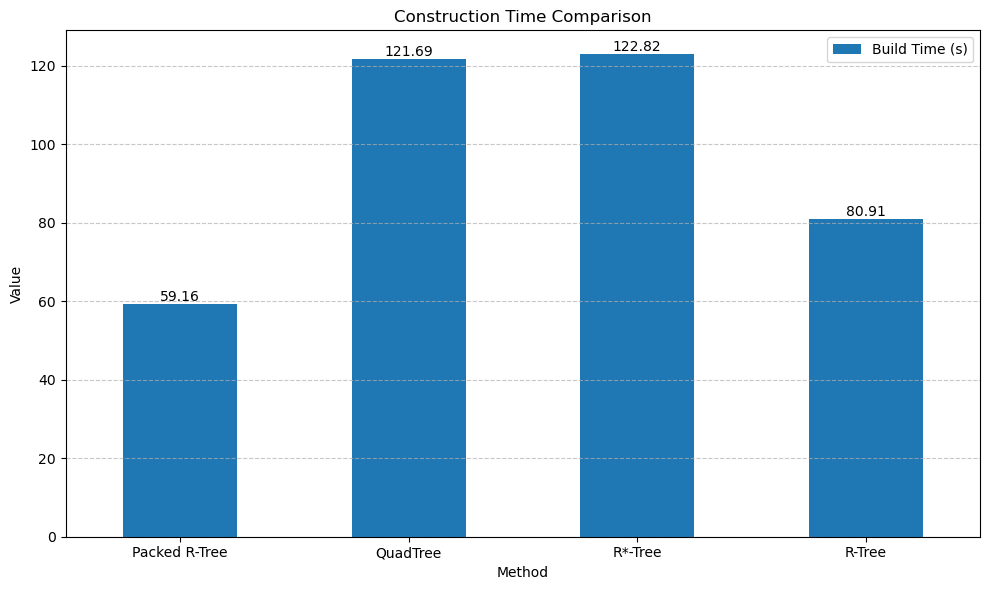

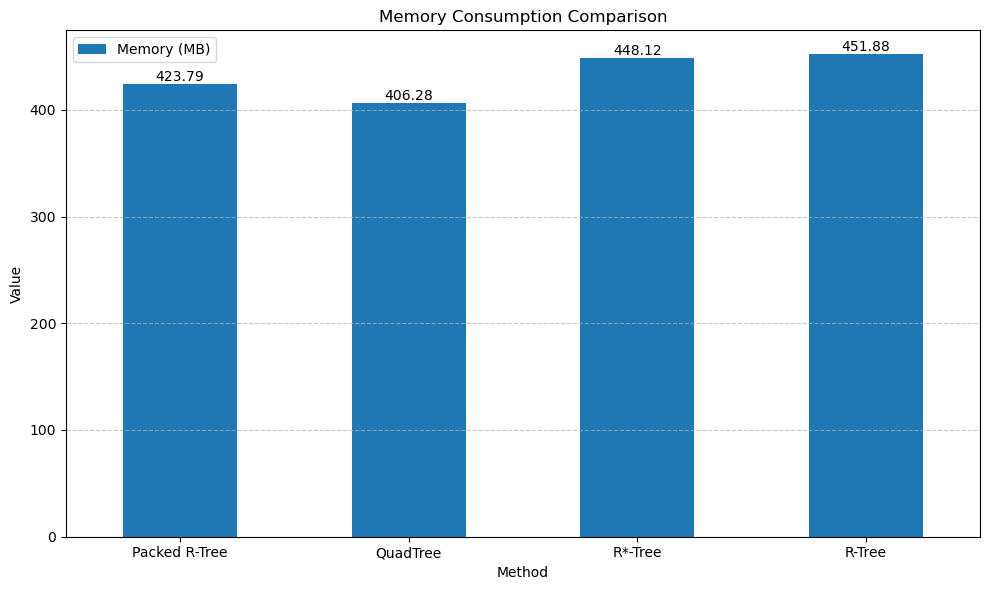

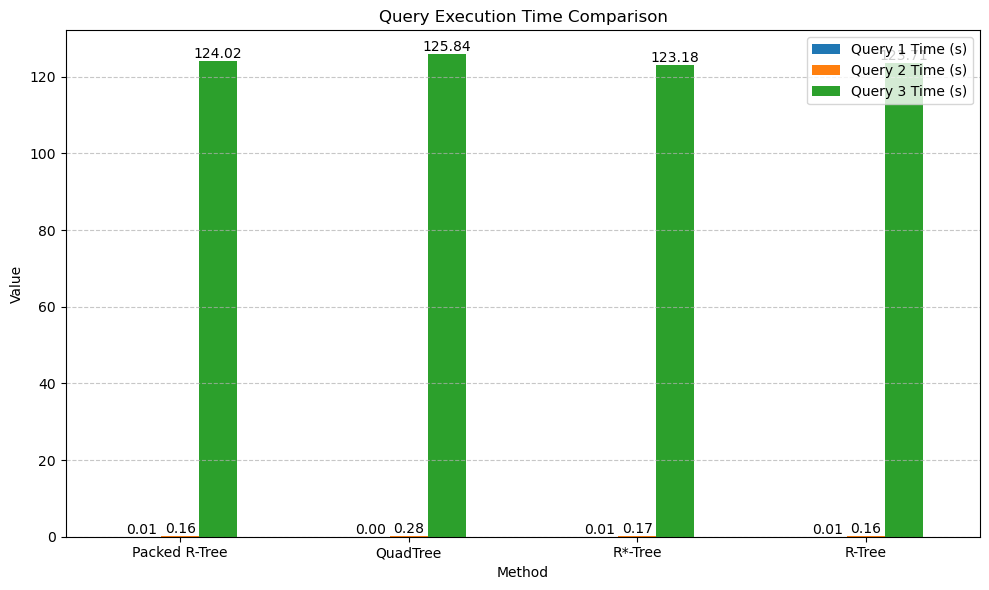


--- Summary Table ---
Metric         Build Time (s)  Memory (MB)  Query 1 Time (s)  \
Method                                                         
Packed R-Tree       59.157399   423.785687          0.005147   
QuadTree           121.691987   406.283525          0.004422   
R*-Tree            122.822006   448.116700          0.005620   
R-Tree              80.911947   451.878926          0.006305   

Metric         Query 2 Time (s)  Query 3 Time (s)  
Method                                             
Packed R-Tree          0.163610        124.022867  
QuadTree               0.283826        125.844253  
R*-Tree                0.166426        123.176440  
R-Tree                 0.156758        123.710556  


In [ ]:
# --- Comprehensive Performance Analysis ---
import time
import sys
import pandas as pd
import matplotlib.pyplot as plt

# 1. Memory Measurement Helper
def get_deep_size(obj, seen=None):
    """Recursively finds size of objects in bytes"""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    seen.add(obj_id)
    
    if isinstance(obj, dict):
        size += sum([get_deep_size(v, seen) for v in obj.values()])
        size += sum([get_deep_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_deep_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_deep_size(i, seen) for i in obj])
    return size

# 2. Tree Construction Wrappers
def build_quadtree_lizard():
    bounds = get_total_bounds(legless_gdf)
    tree = QuadTree(bounds, capacity=20)
    for idx, row in legless_gdf.iterrows():
        tree.insert(row.geometry, idx)
    return tree

def build_quadtree_wetland():
    bounds = get_total_bounds(wetlands_gdf)
    tree = QuadTree(bounds, capacity=20)
    for idx, row in wetlands_gdf.iterrows():
        tree.insert(row.geometry, row)
    return tree

def build_rtree_lizard():
    tree = RTree(capacity=10)
    for idx, row in legless_gdf.iterrows():
        tree.insert(row.geometry, idx)
    return tree

def build_rtree_wetland():
    tree = RTree(capacity=10)
    for idx, row in wetlands_gdf.iterrows():
        tree.insert(row.geometry, row)
    return tree

def build_packed_lizard():
    return build_packed_rtree(legless_gdf, capacity=10)

def build_packed_wetland():
    return build_wetland_packed_rtree(wetlands_gdf, capacity=10)

def build_rstar_lizard():
    tree = RStarTree(capacity=10)
    for idx, row in legless_gdf.iterrows():
        tree.insert(row.geometry, idx)
    return tree

def build_rstar_wetland():
    tree = RStarTree(capacity=10)
    for idx, row in wetlands_gdf.iterrows():
        tree.insert(row.geometry, row)
    return tree

# 3. Test Configuration
methods = [
    {
        "name": "QuadTree",
        "build_lizard": build_quadtree_lizard,
        "build_wetland": build_quadtree_wetland,
        "query_funcs": [run_query_1, run_query_2, run_query_3]
    },
    {
        "name": "R-Tree",
        "build_lizard": build_rtree_lizard,
        "build_wetland": build_rtree_wetland,
        "query_funcs": [run_query_1_rtree, run_query_2_rtree, run_query_3_rtree]
    },
    {
        "name": "Packed R-Tree",
        "build_lizard": build_packed_lizard,
        "build_wetland": build_packed_wetland,
        "query_funcs": [run_query_1_packed, run_query_2_packed, run_query_3_packed]
    },
    {
        "name": "R*-Tree",
        "build_lizard": build_rstar_lizard,
        "build_wetland": build_rstar_wetland,
        "query_funcs": [run_query_1_rstar, run_query_2_rstar, run_query_3_rstar]
    }
]

results = []

print("Starting Comprehensive Performance Tests...")
print("Metrics: Construction Time, Memory Usage, Query Execution Time")

for method in methods:
    m_name = method["name"]
    print(f"\n=== Testing {m_name} ===")
    
    # --- Metric 1: Construction Time ---
    # --- Metric 3: Memory Consumption ---
    
    # Build Lizard Tree
    t0 = time.time()
    l_tree = method["build_lizard"]()
    t1 = time.time()
    l_build_time = t1 - t0
    l_mem = get_deep_size(l_tree) / (1024 * 1024) # MB
    
    # Build Wetland Tree
    t0 = time.time()
    w_tree = method["build_wetland"]()
    t1 = time.time()
    w_build_time = t1 - t0
    w_mem = get_deep_size(w_tree) / (1024 * 1024) # MB
    
    total_build_time = l_build_time + w_build_time
    total_mem = l_mem + w_mem
    
    print(f"  [Build] Time: {total_build_time:.4f}s | Memory: {total_mem:.2f} MB")
    
    results.append({"Method": m_name, "Metric": "Build Time (s)", "Value": total_build_time})
    results.append({"Method": m_name, "Metric": "Memory (MB)", "Value": total_mem})
    
    # --- Metric 2: Query Execution Time ---
    
    # Query 1
    print("  [Query 1] Running...", end="", flush=True)
    # Suppress output for cleaner logs (optional, but keeping it simple here)
    t0 = time.time()
    method["query_funcs"][0](l_tree, legless_gdf, protected_areas_gdf)
    q1_time = time.time() - t0
    print(f" Done ({q1_time:.4f}s)")
    results.append({"Method": m_name, "Metric": "Query 1 Time (s)", "Value": q1_time})
    
    # Query 2
    print("  [Query 2] Running...", end="", flush=True)
    t0 = time.time()
    method["query_funcs"][1](w_tree, wetlands_gdf, protected_areas_gdf)
    q2_time = time.time() - t0
    print(f" Done ({q2_time:.4f}s)")
    results.append({"Method": m_name, "Metric": "Query 2 Time (s)", "Value": q2_time})
    
    # Query 3
    print("  [Query 3] Running...", end="", flush=True)
    t0 = time.time()
    method["query_funcs"][2](w_tree, wetlands_gdf, platypus_gdf)
    q3_time = time.time() - t0
    print(f" Done ({q3_time:.4f}s)")
    results.append({"Method": m_name, "Metric": "Query 3 Time (s)", "Value": q3_time})

# --- Visualization ---
df_res = pd.DataFrame(results)

# Define groups for plotting
plot_groups = [
    ("Construction Time Comparison", ["Build Time (s)"]),
    ("Memory Consumption Comparison", ["Memory (MB)"]),
    ("Query Execution Time Comparison", ["Query 1 Time (s)", "Query 2 Time (s)", "Query 3 Time (s)"])
]

for title, metrics in plot_groups:
    subset = df_res[df_res["Metric"].isin(metrics)]
    if subset.empty: continue
    
    pivot = subset.pivot(index="Method", columns="Metric", values="Value")
    
    ax = pivot.plot(kind='bar', figsize=(10, 6), rot=0)
    plt.title(title)
    plt.ylabel("Value")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title=None)
    
    # Add labels
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f')
        
    plt.tight_layout()
    plt.show()

print("\n--- Summary Table ---")
print(df_res.pivot(index="Method", columns="Metric", values="Value"))

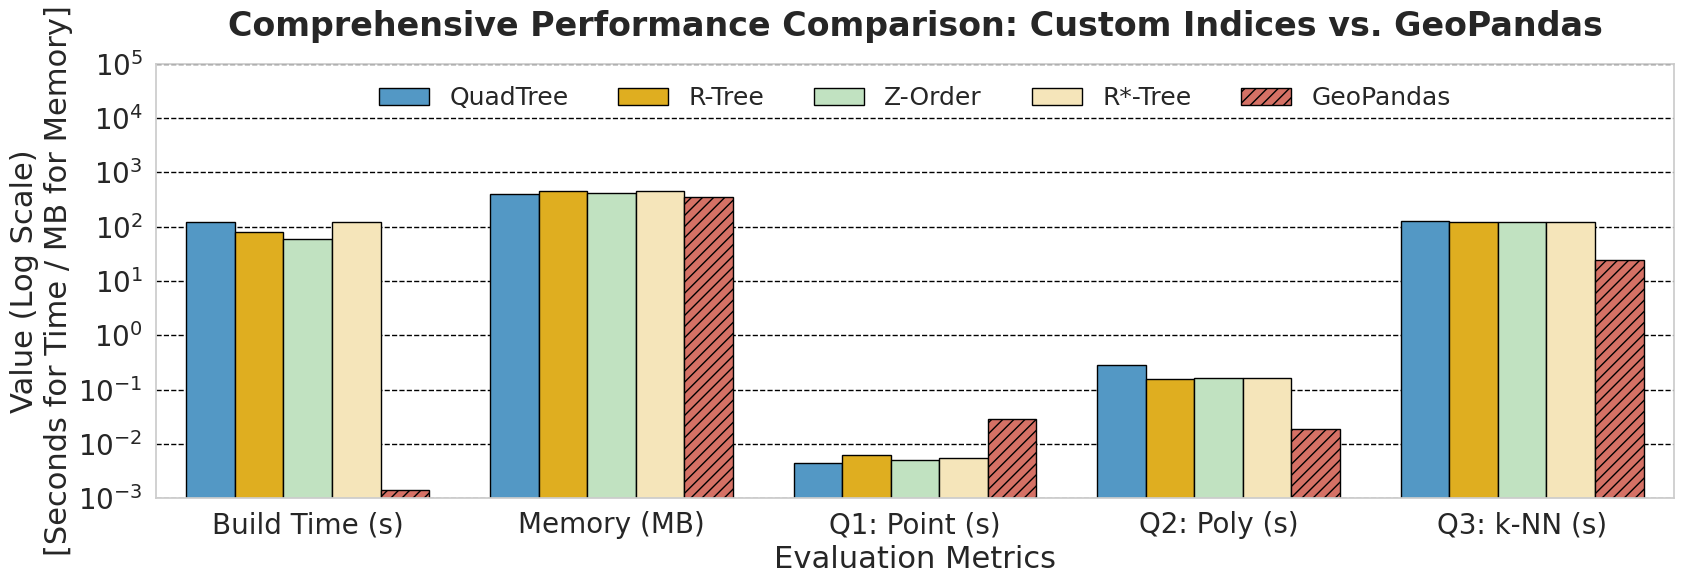

In [73]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

# 1. Data Preparation
# Note: Values are taken directly from your provided logs.
data = {
    'Structure': [
        'QuadTree', 'QuadTree', 'QuadTree', 'QuadTree', 'QuadTree',
        'R-Tree', 'R-Tree', 'R-Tree', 'R-Tree', 'R-Tree',
        'Z-Order', 'Z-Order', 'Z-Order', 'Z-Order', 'Z-Order',
        'R*-Tree', 'R*-Tree', 'R*-Tree', 'R*-Tree', 'R*-Tree',
        'GeoPandas', 'GeoPandas', 'GeoPandas', 'GeoPandas', 'GeoPandas'
    ],
    'Metric': [
        'Build Time (s)', 'Memory (MB)', 'Q1: Point (s)', 'Q2: Poly (s)', 'Q3: k-NN (s)',
        'Build Time (s)', 'Memory (MB)', 'Q1: Point (s)', 'Q2: Poly (s)', 'Q3: k-NN (s)',
        'Build Time (s)', 'Memory (MB)', 'Q1: Point (s)', 'Q2: Poly (s)', 'Q3: k-NN (s)',
        'Build Time (s)', 'Memory (MB)', 'Q1: Point (s)', 'Q2: Poly (s)', 'Q3: k-NN (s)',
        'Build Time (s)', 'Memory (MB)', 'Q1: Point (s)', 'Q2: Poly (s)', 'Q3: k-NN (s)'
    ],
    'Value': [
        # QuadTree
        121.6920, 406.28, 0.0044, 0.2838, 125.8443,
        # R-Tree
        80.9119, 451.88, 0.0063, 0.1568, 123.7106,
        # Z-Order
        59.1574, 423.79, 0.0051, 0.1636, 124.0229,
        # R*-Tree
        122.8220, 448.12, 0.0056, 0.1664, 123.1764,
        # GeoPandas
        0.0014, 358.21, 0.0294, 0.0191, 24.4057
    ]
}

df = pd.DataFrame(data)

# 2. Plotting Configuration
# Adjusted figsize to 15:3 ratio (Width 15, Height 3)
plt.figure(figsize=(17, 6))
sns.set_theme(style="whitegrid")

# Custom color palette
palette = {
    'QuadTree': '#409cd8',      # Blue
    'R-Tree': '#ffbd00',        # Yellow
    'Z-Order': '#bbe7bb', # Light Green
    'R*-Tree': '#ffeab0',       # Light Pink
    'GeoPandas': '#e86252'      # Red
}

# Define explicit hue order to ensure we can target GeoPandas correctly
hue_order = ['QuadTree', 'R-Tree', 'Z-Order', 'R*-Tree', 'GeoPandas']

# Create Bar Plot
chart = sns.barplot(
    data=df,
    x='Metric',
    y='Value',
    hue='Structure',
    hue_order=hue_order,
    palette=palette,
    edgecolor='black',
    linewidth=1
)

# Apply hatching to GeoPandas bars
# GeoPandas is the last item in hue_order, so it corresponds to the last container
# Note: chart.containers contains patches for each hue level
geopandas_container = chart.containers[4] 
for bar in geopandas_container:
    bar.set_hatch('///')

# 3. Formatting
# Logarithmic scale is crucial due to the mix of MB (300+) and fast queries (0.001s)
plt.yscale('log')
plt.ylim(0.001, 100000)

# Labels and Titles
plt.title('Comprehensive Performance Comparison: Custom Indices vs. GeoPandas', fontsize=24, fontweight='bold', pad=20)
plt.ylabel('Value (Log Scale)\n[Seconds for Time / MB for Memory]', fontsize=22)
plt.xlabel('Evaluation Metrics', fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.grid(axis='y', linestyle='--', color='black', alpha=1.0, zorder=0)

# Legend placement
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1), ncol=5, frameon=False, fontsize=18)

plt.tight_layout()

# Save or Show
plt.savefig('performance_comparison.pdf', dpi=300, bbox_inches='tight')
plt.show()